In [1]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from alse.eci import ExpectedCoverageImprovement

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

In [3]:
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return v.unsqueeze(-1)

In [4]:
import pandas
real_data = pandas.read_excel('data1.xlsx')

power = torch.tensor(real_data.loc[:,"P (W)"], dtype=torch.float)
velocity = torch.tensor(real_data.loc[:,"V (mm/min)"], dtype=torch.float)
width = torch.tensor(real_data.loc[:,"widths avg (mm)"], dtype=torch.float).unsqueeze(-1)
pow_cap = torch.tensor(real_data.loc[:,"powder capt %"]/100, dtype=torch.float).unsqueeze(-1)

X = torch.stack((power, velocity), -1)

In [5]:
def get_and_fit_gp(X, Y):
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [6]:
#               width > 2.5  powder capture > 50%
constraints = [("gt", 2.5), ("gt", 0.5)]

bounds = torch.tensor([[200, 200], [3000, 3000]], **tkwargs)
lb, ub = bounds


In [7]:
gp_model_width = get_and_fit_gp(X, width)
gp_model_pow_cap = get_and_fit_gp(X, pow_cap)

In [8]:
N1, N2 = 10, 10
Xplt, Yplt = torch.meshgrid(
    torch.linspace(200, 3000, N1, **tkwargs), torch.linspace(200, 3000, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)

In [9]:
predicted_width = gp_model_width(xplt).loc.detach().reshape(N1,N2)
predicted_pow_cap = gp_model_pow_cap(xplt).loc.detach()

In [10]:
test_point = torch.tensor([[315,  200]])
gp_model_width(test_point.float()).loc.detach()

tensor([2.5508])

In [11]:
gp_model_width.covar_module.base_kernel.lengthscale

tensor([[0.6013, 0.6013]], grad_fn=<SoftplusBackward0>)

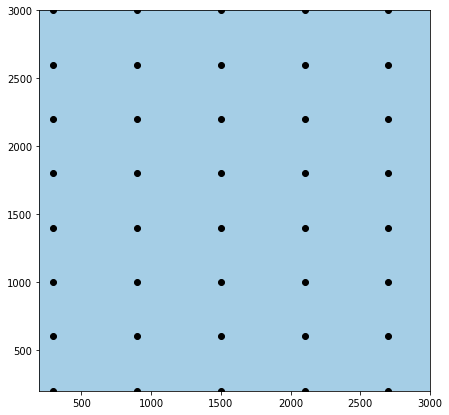

In [12]:
plt.subplots(figsize=(7, 7))
plt.contourf(Xplt, Yplt, predicted_width, cmap="Blues", alpha=0.6)
plt.plot(X[:,0], X[:,1], "ko")
